In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import yfinance as yf
import fxcmpy

/var/folders/vt/l70v337s047_p4k5c0kp45200000gn/T/ipykernel_36568/189156971.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


In [21]:


class LogisticRegressionBacktester():
    ''' Class for the vectorized backtesting of Machine Learning-based trading strategies (Classification).
    '''

    def __init__(self, symbol, start, end, tc, api, frequency):
        '''
        Parameters
        ----------
        symbol: str
            ticker symbol (instrument) to be backtested
        start: str
            start date for data import
        end: str
            end date for data import
        tc: float
            proportional transaction/trading costs per trade
        '''
        self.symbol = symbol
        self.start = start
        self.end = end
        self.tc = tc
        self.model = LogisticRegression(C = 1e6, max_iter = 100000, multi_class = "ovr")
        self.results = None
        self.api=api
        self.frequency=frequency
        self.get_data()
    
    def __repr__(self):
        rep = "MLBacktester(symbol = {}, start = {}, end = {}, tc = {})"
        return rep.format(self.symbol, self.start, self.end, self.tc)
                             
                     
    def get_data(self):
        ''' Imports the data from FXCM if api is provided else data is imported from yahoo-Finance.
        '''
        if self.api is None:
            raw = yf.download(self.symbol,self.start,self.end).Close.to_frame()
            raw = raw.rename(columns={'Close':'price'})
            raw["returns"] = np.log(raw / raw.shift(1))
            self.data = raw
        else:
            raw = self.api.get_candles(self.symbol, start = self.start, end = self.end, period = self.frequency)
            raw = raw['askclose'].to_frame()
            raw = raw.rename(columns={'askclose':'price'})
            raw["returns"] = np.log(raw / raw.shift(1))
            self.data = raw


    def split_data(self, start, end):
        ''' Splits the data into training set & test set.
        '''
        data = self.data.loc[start:end].copy()
        return data
    
    def prepare_features(self, start, end):
        ''' Prepares the feature columns for training set and test set.
        '''
        self.data_subset = self.split_data(start, end)
        self.feature_columns = []
        for lag in range(1, self.lags + 1):
            col = "lag{}".format(lag)
            self.data_subset[col] = self.data_subset["returns"].shift(lag)
            self.feature_columns.append(col)
        self.data_subset.dropna(inplace=True)
        
    def fit_model(self, start, end):
        ''' Fitting the ML Model.
        '''
        self.prepare_features(start, end)
        self.model.fit(self.data_subset[self.feature_columns], np.sign(self.data_subset["returns"]))
        
    def test_strategy(self, train_ratio = 0.7, lags = 5):
        ''' 
        Backtests the ML-based strategy.
        
        Parameters
        ----------
        train_ratio: float (between 0 and 1.0 excl.)
            Splitting the dataset into training set (train_ratio) and test set (1 - train_ratio).
        lags: int
            number of lags serving as model features.
        '''
        self.lags = lags
                  
        # determining datetime for start, end and split (for training an testing period)
        full_data = self.data.copy()
        split_index = int(len(full_data) * train_ratio)
        split_date = full_data.index[split_index-1]
        train_start = full_data.index[0]
        test_end = full_data.index[-1]
        
        # fit the model on the training set
        self.fit_model(train_start, split_date)
        
        # prepare the test set
        self.prepare_features(split_date, test_end)
                  
        # make predictions on the test set
        predict = self.model.predict(self.data_subset[self.feature_columns])
        self.data_subset["pred"] = predict
        
        # calculate Strategy Returns
        self.data_subset["strategy"] = self.data_subset["pred"] * self.data_subset["returns"]
        
        # determine the number of trades in each bar
        self.data_subset["trades"] = self.data_subset["pred"].diff().fillna(0).abs()
        
        # subtract transaction/trading costs from pre-cost return
        self.data_subset.strategy = self.data_subset.strategy - self.data_subset.trades * self.tc
        
        # calculate cumulative returns for strategy & buy and hold
        self.data_subset["creturns"] = self.data_subset["returns"].cumsum().apply(np.exp)
        self.data_subset["cstrategy"] = self.data_subset['strategy'].cumsum().apply(np.exp)
        self.results = self.data_subset
        
        perf = self.results["cstrategy"].iloc[-1] # absolute performance of the strategy
        outperf = perf - self.results["creturns"].iloc[-1] # out-/underperformance of strategy
        
        return round(perf, 6), round(outperf, 6)
        
    def plot_results(self):
        ''' Plots the performance of the trading strategy and compares to "buy and hold".
        '''
        if self.results is None:
            print("Run test_strategy() first.")
        else:
            title = "Logistic Regression: {} | TC = {}".format(self.symbol, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))

    def optimize_parameters(self,max_lags):
        optimal=[]
        for lags in range(1, max_lags + 1):
            temp = self.test_strategy(train_ratio = 0.7, lags = lags)
            optimal.append(temp[0])

        for i in range(len(optimal)):
            if optimal[i] == max(optimal):
                print("Optimal number of lags is {} with a performance of {}".format(i+1, optimal[i]))
                break

In [4]:
api = fxcmpy.fxcmpy(config_file= "FXCM.cfg")

In [54]:
stocks = LogisticRegressionBacktester("EUR/USD", "2018-01-01", "2019-10-01", 0.000,api,'H8')

In [58]:
stocks.test_strategy(train_ratio = 0.7, lags = 9)

(1.005144, 0.038421)

In [56]:
stocks.optimize_parameters(10)

Optimal number of lags is 9 with a performance of 1.005144


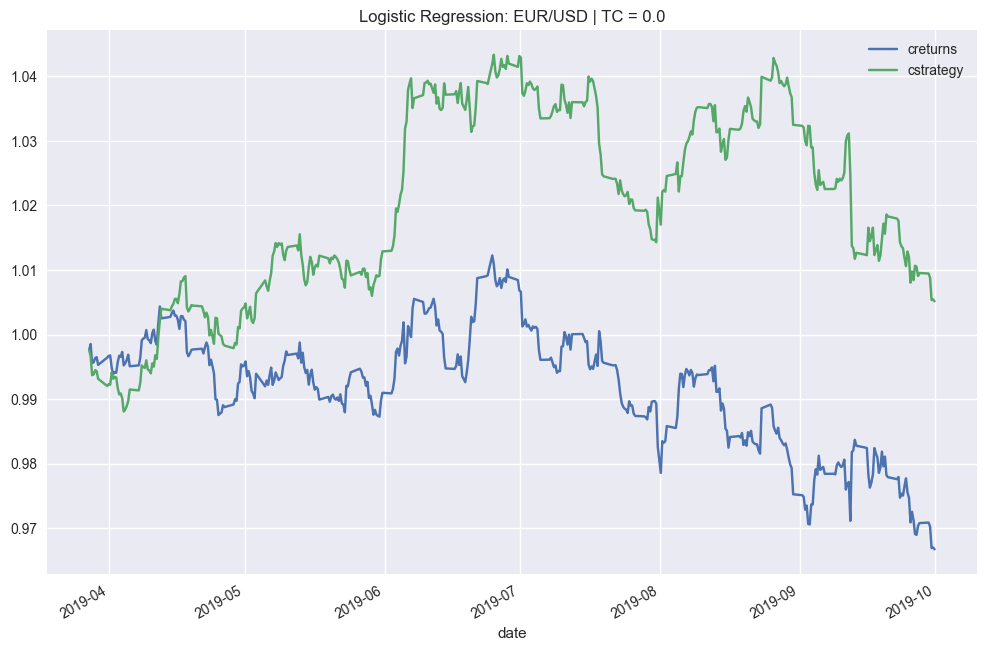

In [59]:
stocks.plot_results()